In [1]:
# Install codeium-jupyter autocompletion software
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U codeium-jupyter

In [2]:
# Import dependencies
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import numpy as np
from dfuncs import dfuncs
from matplotlib.gridspec import GridSpec
from numba import njit
from scipy.optimize import minimize, Bounds
from sympy import symbols, solve, lambdify

In [3]:
# Get experimental data from the dfuncs module
CPD, ROT3, BES1, AUXIN, SIZE, POSITION = dfuncs().values()
STEP = 0.15

# Define the time step, BR precursor, and auxin vectors
vT = np.arange(0, 15 + STEP, STEP)
vI = np.arange(0, len(vT), len(vT) // 10)
vP = (CPD(POSITION(vT)) + ROT3(POSITION(vT))) / 100
vA = AUXIN(POSITION(vT))

# Define the vectors of experimental data
vSIZE = SIZE(POSITION(vT))
vBES1 = BES1(POSITION(vT))

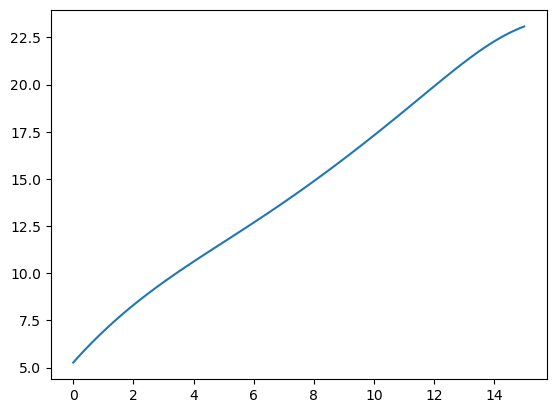

In [4]:
# Calculate the vB function, assuming p_in = 1, b_out = 0.2
vB, b = np.array([]), 5
for i, p in enumerate(vP):
    dB = p - 0.2 * b
    b = b + dB * STEP
    vB = np.append(vB, b)

plt.plot(vT, vB)

In [5]:
def setup(config):

    # Define parameters and variables
    params = symbols('c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M')
    c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M = params
    
    # Define the symbols representing hormone levels
    C, R0, RB, M, B, A, L = symbols('C R0 RB M B A L')

    # Construct some expressions based on the configuration
    sq, hill, auxin, lmul, tfbs = config
    B_1 = B**2 if sq else B
    B_2 = (B_1 / (1 + b * B_1)) if hill else B_1
    L_m = L if lmul else 1
    L_1 = (1 + (g_A * A)) if auxin else 1
    L_2 = (1 + (g_M * M)) if tfbs else 1
            
    # Write the hormone equations down as a system
    hormone_eqn = [
        c_max - (1 + q * RB) * C,
        u * (1 + v * C) - (k_on * R0 * B_2) + (k_off * RB) - R0,
        (k_on * R0 * B_2) - (1 + k_off) * RB,
        (a_M * C / L) - M
    ]

    # Solve hormone equations, choosing the second root to ensure positive solutions
    hormone_ss = solve(hormone_eqn, [C, R0, RB, M], dict = True)[-1]
    fC, fR0, fRB, fM = [njit(lambdify([*params, B, L], hormone_ss[h])) for h in [C, R0, RB, M]]

    # Write down the growth equation and convert it into a lambda function
    growth_eqn = (g_B * RB * L_m) / (L_1 * L_2)
    fdL = njit(lambdify([*params, RB, A, M, L], growth_eqn))

    # Return the list of lambda functions
    return [fC, fR0, fRB, fM, fdL]

In [6]:
# Create the space of configuration tuples
config_space = list(itertools.product([False, True], repeat=5))

# Create the simulation tuples (description, funcs)
simulations = [(config, setup(config)) for config in config_space]

In [7]:
@njit
def RMSE(predicted, observed):
    residuals = np.square(predicted - observed)
    rss = np.sum(residuals)
    return rss / residuals.shape[0]

@njit
def simulate_cell(params, C, R0, RB, M, dL):

    # Unpack the list of parameters
    c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M = params
    
    # Initialize hormone values (c, r0, rb, m) and length value
    vC, c   = np.array([np.float64(x) for x in range(0)]), 0
    vR0, r0 = np.array([np.float64(x) for x in range(0)]), 0
    vRB, rb = np.array([np.float64(x) for x in range(0)]), 0
    vM, m   = np.array([np.float64(x) for x in range(0)]), 0
    vL, l   = np.array([np.float64(x) for x in range(0)]), vSIZE[0]
    
    # Run the simulation one time step at a time
    for i in range(vB.shape[0]):

        # Get the current time step and external hormone values
        b = vB[i]
        a = vA[i]
        
        # Update each of the steady-state hormone values
        c  =  C(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)
        r0 = R0(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)
        rb = RB(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)
        m  =  M(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, b, l)

        # Append the steady-state hormone values to the hormone vectors
        vC = np.append(vC, c)
        vR0 = np.append(vR0, r0)
        vRB = np.append(vRB, rb)
        vM = np.append(vM, m)

        # Update the length vector
        l = l + dL(c_max, q, u, v, k_on, k_off, b, a_M, g_B, g_A, g_M, rb, a, m, l) * STEP
        vL = np.append(vL, l)
    
    # Compute the BR signalling and NRMSE of trial run
    vS = vRB * q
    return [vC, vR0, vS, vM, vL], [RMSE(vL, vSIZE), RMSE(vS, vBES1)]

## Model Fitting

In [8]:
# Convert configuration tuple into a written description
def get_description(config):
    d = []
    d.append(r"$B^2$" if config[0] else r"$B$") 
    if config[1]: d.append("Hill")
    if config[2]: d.append("Auxin")
    if config[3]: d.append("L-Scaled")
    if config[4]: d.append("TFBs")
    return ", ".join(d)

In [9]:
# Run each of the simulations and print the best error
results = []
for sim in simulations:

    # Define a cost function with the given simulation
    config, (C, R0, RB, M, dL) = sim
    description = get_description(config)
    cost = lambda params : sum(simulate_cell(params, C, R0, RB, M, dL)[-1])

    # Find the parameters of best fit
    fit = minimize(
        cost, 
        np.array([1, 1, 1, 1, 1, 1, 0.001, 1, 1, 1, 1]), 
        method = "trust-constr",
        bounds = Bounds(0.001, 1000), 
        options = {"maxiter": 10000}
    )

    # Get the number of parameters
    nparams = 8 + int(config[1]) + int(config[2]) + int(config[4])

    # Run a simulation with the optimal parameters
    data, error = simulate_cell(fit.x, C, R0, RB, M, dL)

    # Log the simulation
    print(description)
    print("Success: ", fit.success, fit.message)
    print("Params: ", [round(n, 4) for n in fit.x])
    print("Length Error: ", error[0])
    print("Signal Error: ", error[1])
    print("Total Error: ", sum(error))
    print("AIC: ", 2 * nparams + vT.shape[0] * np.log(sum(error)), "\n")

    # Add the simulation data to the results results
    results.append((config, data, sum(error)))

/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$
Success:  True `xtol` termination condition is satisfied.
Params:  [0.0036, 501.7784, 504.6603, 0.0023, 0.001, 122.9924, 34.017, 34.8439, 40.9041, 34.5202, 55.971]
Length Error:  70.32130741028584
Signal Error:  34.60725797578539
Total Error:  104.92856538607123
AIC:  485.981258686154 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [16.3224, 44.9591, 247.3336, 0.001, 0.001, 4.4228, 31.8566, 19.5292, 262.4219, 20.3397, 121.5536]
Length Error:  1.404053872201658
Signal Error:  34.87302710139847
Total Error:  36.27708097360013
AIC:  380.70980253672536 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [0.0011, 616.0915, 793.0069, 0.001, 0.001, 237.8808, 12.1059, 44.8773, 2.9095, 60.8789, 19.7841]
Length Error:  14.325274525230638
Signal Error:  34.60214875270573
Total Error:  48.92742327793637
AIC:  408.92414229444364 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [3.7135, 88.2709, 90.3134, 0.0011, 0.0015, 4.9135, 7.3534, 7.1626, 0.7386, 46.6555, 13.3793]
Length Error:  0.8041059236905332
Signal Error:  34.942210852673846
Total Error:  35.74631677636438
AIC:  379.2211708963762 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Auxin
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.0026, 45.2133, 999.8768, 0.0027, 0.001, 21.2357, 90.1218, 249.316, 999.9143, 229.289, 161.658]
Length Error:  41.08481763245247
Signal Error:  34.655937461756494
Total Error:  75.74075509420896
AIC:  455.05895559002533 

$B$, Auxin, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [10.1394, 28.7302, 107.1332, 0.001, 0.0897, 132.524, 17.4173, 25.476, 105.47, 0.6724, 52.9003]
Length Error:  0.6537774427800367
Signal Error:  35.49578313275406
Total Error:  36.1495605755341
AIC:  382.3541440873449 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Auxin, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.0027, 16.044, 2.5771, 19.748, 8.6095, 41.5237, 28.5339, 0.0056, 0.8963, 10.2752, 1.4213]
Length Error:  16.55179779497735
Signal Error:  143.96111348495157
Total Error:  160.51291127992891
AIC:  530.9158127280787 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [1.5166, 116.0186, 120.5306, 0.0012, 0.0155, 105.0535, 40.346, 11.3444, 1.7472, 0.949, 14.7666]
Length Error:  0.19090509140425602
Signal Error:  34.79252326353369
Total Error:  34.98342835493794
AIC:  379.04232185291715 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill
Success:  True `xtol` termination condition is satisfied.
Params:  [57.3393, 143.6363, 0.001, 103.2393, 999.9972, 0.001, 35.6687, 69.736, 9.7584, 49.4304, 108.7674]
Length Error:  112.76867882615531
Signal Error:  212.6156882609367
Total Error:  325.384367087092
AIC:  602.2857223004072 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [246.4307, 0.0029, 30.4859, 39.779, 999.9994, 0.001, 99.3261, 153.3625, 3.4521, 37.0367, 214.2264]
Length Error:  52.124064838802916
Signal Error:  212.6137403371093
Total Error:  264.73780517591223
AIC:  583.4527320979767 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [224.2704, 0.2264, 0.1143, 147.2634, 999.9997, 0.001, 95.8936, 11.8708, 0.001, 13.3305, 13.9993]
Length Error:  51.79758494397755
Signal Error:  212.6116563888742
Total Error:  264.40924133285176
AIC:  581.3273040052266 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [11.4725, 135.7512, 0.0138, 39.0101, 215.7604, 0.0033, 36.734, 77.5952, 13.3154, 165.7226, 10.9402]
Length Error:  5.0708546342974055
Signal Error:  219.75123885229755
Total Error:  224.82209348659495
AIC:  566.9462487762877 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin
Success:  True `xtol` termination condition is satisfied.
Params:  [177.6126, 0.7606, 0.1576, 39.9921, 999.9971, 0.001, 46.1745, 88.9283, 41.6898, 583.703, 99.0515]
Length Error:  71.80994049349532
Signal Error:  212.6148732915545
Total Error:  284.4248137850498
AIC:  590.6973633156065 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [110.1957, 0.001, 20.0581, 386.4873, 999.9863, 0.001, 47.9924, 121.7684, 183.9626, 579.4122, 128.1653]
Length Error:  20.44565478769107
Signal Error:  212.6115303809332
Total Error:  233.05718516862427
AIC:  572.5796691894576 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [11.7062, 89.3461, 0.0935, 8.481, 42.3643, 0.0037, 0.0183, 0.1782, 10.6621, 20.4305, 0.8507]
Length Error:  24.65877222648868
Signal Error:  251.6528947688639
Total Error:  276.31166699535254
AIC:  587.7744751431168 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B$, Hill, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [95.2997, 0.7653, 0.1893, 61.6396, 999.9839, 0.001, 256.796, 38.6164, 1.6042, 82.1179, 0.4739]
Length Error:  0.49631959384176516
Signal Error:  212.61577874488557
Total Error:  213.11209833872735
AIC:  563.5436493656873 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$
Success:  False The maximum number of function evaluations is exceeded.
Params:  [2.0505, 177.1397, 154.6327, 0.684, 0.001, 249.6659, 25.0063, 30.3052, 18.7445, 49.6225, 29.9011]
Length Error:  39.71502504120923
Signal Error:  15.815938960655838
Total Error:  55.53096400186507
AIC:  421.71101828732327 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [50.5144, 191.2153, 186.5262, 0.2003, 0.001, 393.9345, 20.8821, 1.1828, 111.7071, 79.2448, 46.3371]
Length Error:  0.08000882752394553
Signal Error:  10.77243261212492
Total Error:  10.852441439648866
AIC:  258.82339728745205 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [1.0098, 45.784, 4.2085, 0.877, 0.0018, 1.445, 0.001, 1.2667, 0.2422, 1.6339, 0.0011]
Length Error:  3.2257087885862963
Signal Error:  16.768537776032428
Total Error:  19.994246564618724
AIC:  318.53990060034613 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, L-Scaled, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.5372, 192.934, 178.6073, 19.1271, 0.001, 381.7321, 27.5543, 9.5415, 1.2468, 55.9086, 18.6124]
Length Error:  0.6971593058070246
Signal Error:  10.772226143095514
Total Error:  11.469385448902539
AIC:  264.40781642157975 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin
Success:  True `xtol` termination condition is satisfied.
Params:  [4.9575, 21.5401, 439.6851, 0.9506, 0.0021, 191.6875, 33.6176, 9.4904, 595.7611, 254.5242, 0.9049]
Length Error:  25.787138297955384
Signal Error:  12.139342223804803
Total Error:  37.92648052176018
AIC:  385.20060582467613 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [1.0291, 151.5761, 214.5176, 9.9487, 0.001, 360.047, 32.073, 75.1925, 95.2345, 0.0896, 35.0636]
Length Error:  0.06154966847875272
Signal Error:  10.773338348241968
Total Error:  10.83488801672072
AIC:  260.6599012602944 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin, L-Scaled
Success:  False The maximum number of function evaluations is exceeded.
Params:  [0.6074, 64.1054, 63.0305, 15.1781, 0.001, 42.7601, 6.5865, 18.3431, 26.6265, 77.005, 5.9527]
Length Error:  1.0112196588553763
Signal Error:  10.927121527607552
Total Error:  11.938341186462928
AIC:  268.4552720898016 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [14.5973, 100.877, 119.1594, 0.6994, 0.001, 132.3937, 23.1363, 0.3963, 1.1655, 0.8813, 9.5991]
Length Error:  0.19298726057694499
Signal Error:  10.805296550772033
Total Error:  10.998283811348978
AIC:  262.1716635911099 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill
Success:  True `xtol` termination condition is satisfied.
Params:  [75.268, 12.5288, 0.026, 34.4555, 999.9301, 0.0011, 36.4873, 70.4801, 0.8512, 35.4063, 57.5426]
Length Error:  112.77115609139798
Signal Error:  212.63162577687027
Total Error:  325.4027818682682
AIC:  602.2914381259342 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, TFBs
Success:  False The maximum number of function evaluations is exceeded.
Params:  [22.1755, 39.1779, 0.0883, 11.6545, 70.2155, 0.0047, 1.8218, 0.4031, 2.6233, 3.613, 0.403]
Length Error:  115.89178807017858
Signal Error:  236.36562304383799
Total Error:  352.2574111140166
AIC:  612.3005811815082 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [168.0052, 0.2264, 0.2594, 86.4879, 999.9995, 0.001, 57.5926, 155.5782, 0.001, 91.9695, 19.4628]
Length Error:  51.7993905428691
Signal Error:  212.6221514693748
Total Error:  264.4215420122439
AIC:  581.3320025540174 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [125.4365, 0.6554, 0.5009, 20.5285, 999.9831, 0.001, 65.5937, 7.1985, 0.0483, 39.8849, 8.0205]
Length Error:  4.836053406264551
Signal Error:  212.63151351215018
Total Error:  217.46756691841472
AIC:  563.5870219011048 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin
Success:  True `xtol` termination condition is satisfied.
Params:  [423.2402, 0.5705, 0.0079, 447.2301, 999.9995, 0.001, 104.5216, 50.4449, 34.7185, 648.2059, 49.9156]
Length Error:  71.80511615260158
Signal Error:  212.62029642758222
Total Error:  284.4254125801838
AIC:  590.6975759491108 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [277.9069, 0.0013, 18.4413, 132.0432, 999.9987, 0.001, 42.8977, 135.6569, 481.9115, 459.162, 119.4508]
Length Error:  20.443390724005138
Signal Error:  212.62094137185102
Total Error:  233.06433209585614
AIC:  572.5827664060577 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin, L-Scaled
Success:  True `xtol` termination condition is satisfied.
Params:  [127.654, 0.2255, 0.0622, 477.4572, 999.9998, 0.001, 169.188, 75.0492, 1.1551, 940.6142, 174.8151]
Length Error:  20.244323534709444
Signal Error:  212.62061980756155
Total Error:  232.864943342271
AIC:  570.4963229632306 



/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


$B^2$, Hill, Auxin, L-Scaled, TFBs
Success:  True `xtol` termination condition is satisfied.
Params:  [23.4666, 0.3602, 1.0986, 90.8321, 999.911, 0.0011, 200.9719, 1.8329, 0.5269, 56.927, 40.6248]
Length Error:  0.49637208129478044
Signal Error:  212.63410716412335
Total Error:  213.13047924541814
AIC:  563.5523602344487 



In [10]:
# Sort out the top results
sorted_results = sorted(results, key = lambda d: d[2])

## Data Visualization

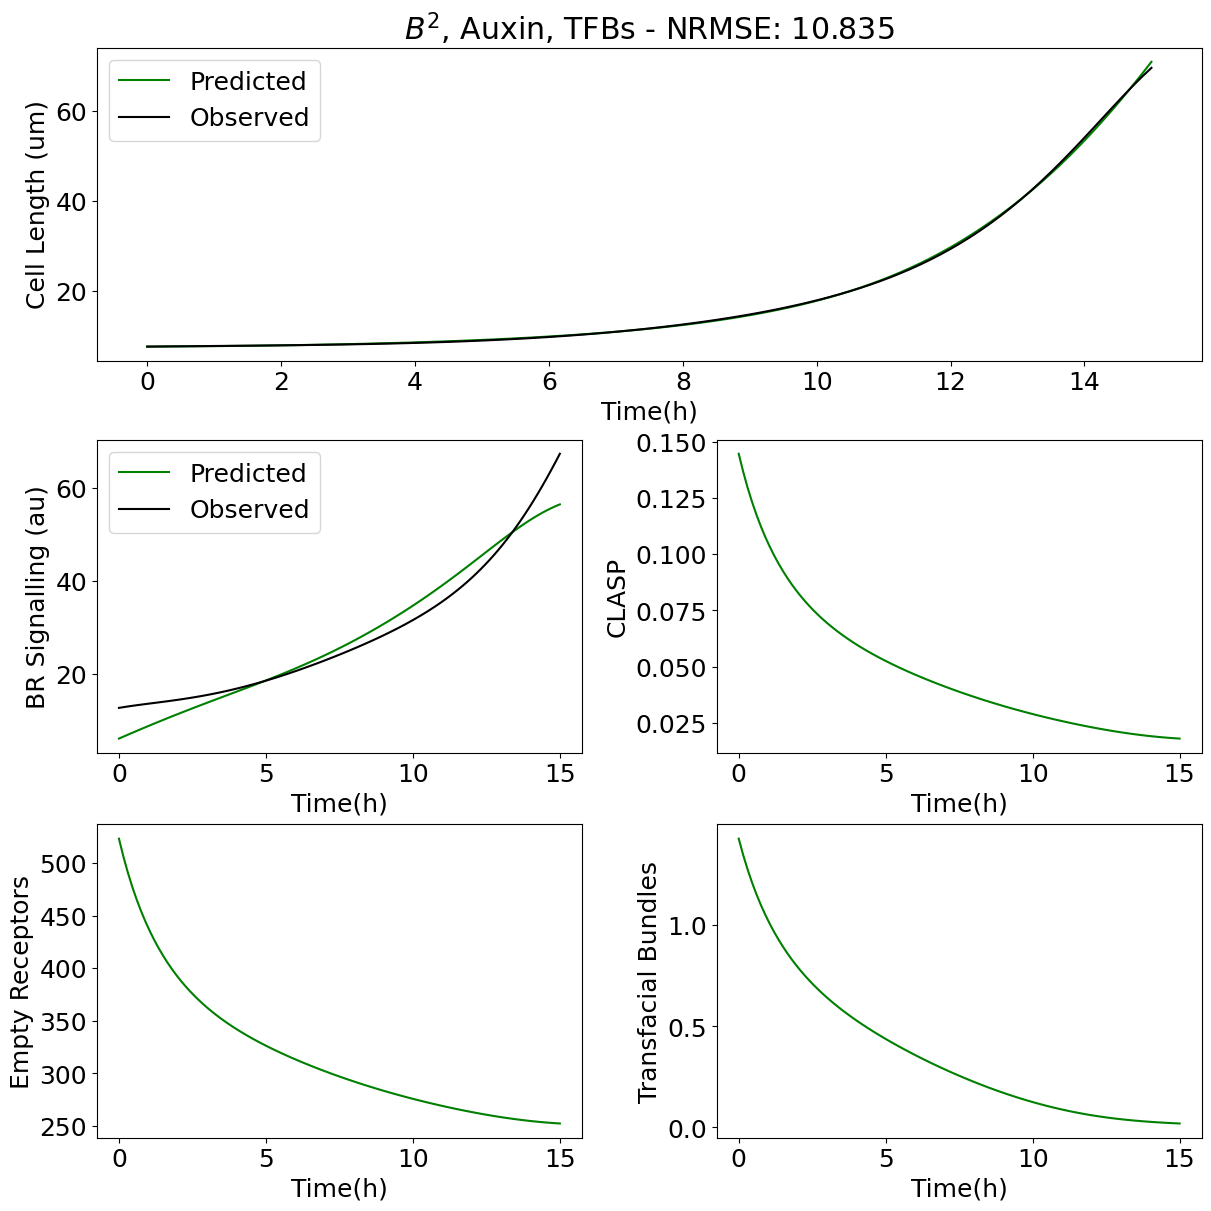

In [11]:
# Plot data from the best overall result
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.size'] = 18

config, (vC, vR0, vS, vM, vL), error = sorted_results[0]
description = get_description(config)
fig = plt.figure(layout = "constrained")

gs = GridSpec(3, 2, figure=fig)
a1 = fig.add_subplot(gs[0, :])
a2 = fig.add_subplot(gs[1, 0])
a3 = fig.add_subplot(gs[1, 1])
a4 = fig.add_subplot(gs[2, 0])
a5 = fig.add_subplot(gs[2, 1])

def plot_axis(a, y1, ylabel, y2 = []):
    a.plot(vT, y1, color = "green", label="Predicted")
    if any(y2): 
        a.plot(vT, y2, color = "black", label = "Observed")
        a.legend()
    a.set_xlabel("Time(h)")
    a.set_ylabel(ylabel)

a1.set_title(description + " - NRMSE: " + str(round(error, 3)))
plot_axis(a1, vL, "Cell Length (um)", vSIZE)
plot_axis(a2, vS, "BR Signalling (au)", vBES1)   
plot_axis(a3, vC, "CLASP")
plot_axis(a4, vR0, "Empty Receptors")
plot_axis(a5, vM, "Transfacial Bundles")

# fig.savefig("img/prototype-3d-best-fit.png")
plt.show()

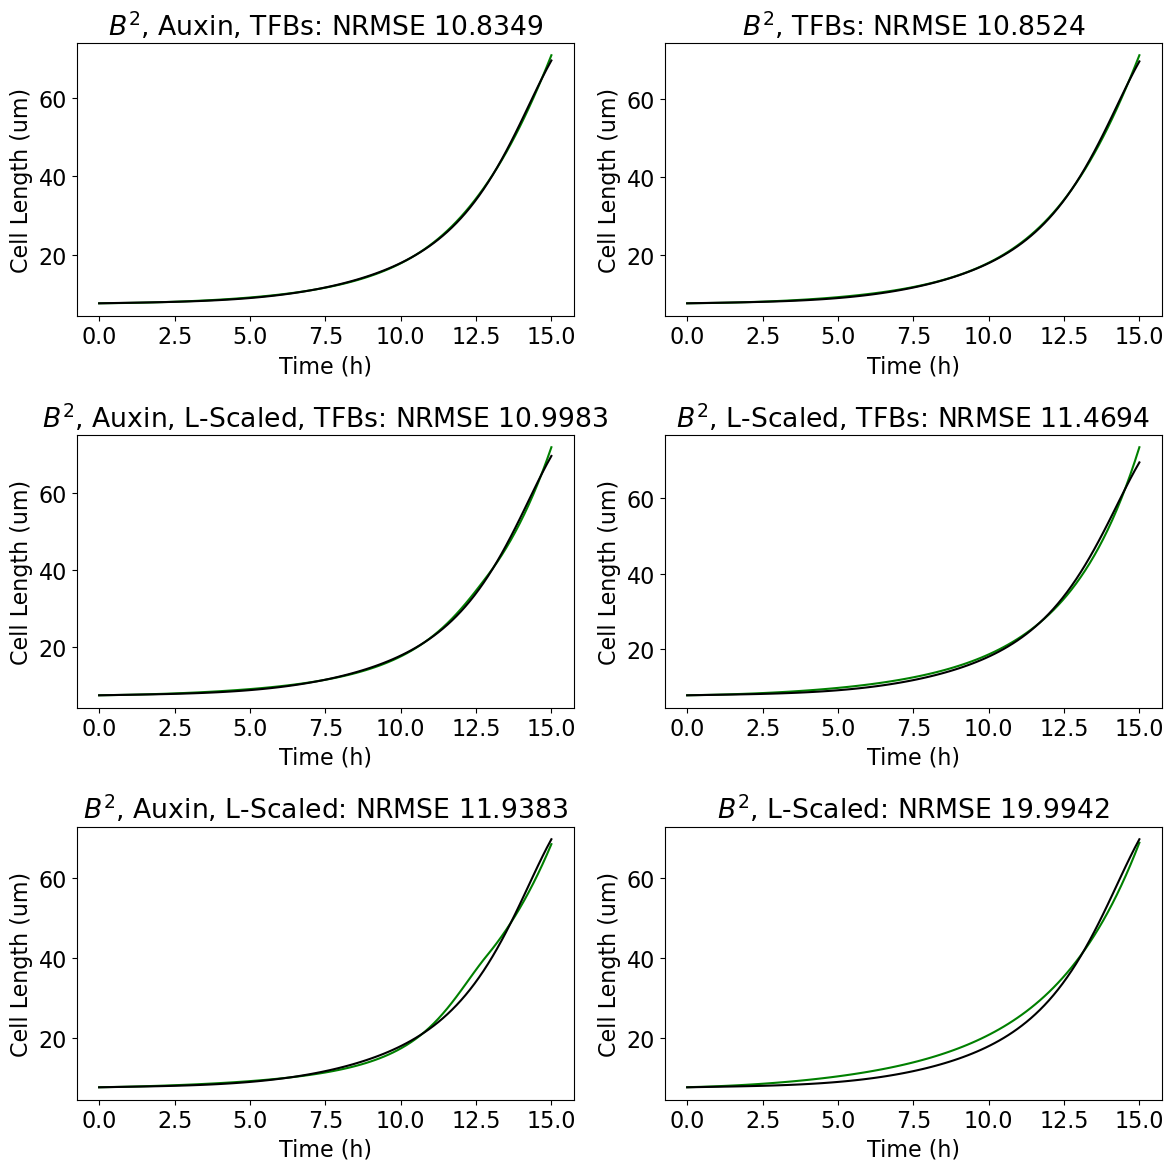

In [12]:
# Plot the six best cell length fits
mpl.rcParams['font.size'] = 16
fig, axes = plt.subplots(nrows = 3, ncols = 2)
axes = [a for row in axes for a in row]

for (a, r) in zip(axes, sorted_results):
    config, (vC, vR0, vS, vM, vL), error = r
    description = get_description(config)
    a.plot(vT, vL, color = "green", label = "Fitted Model")
    a.plot(vT, vSIZE, color = "black", label = "Experimental Data")
    a.set_xlabel("Time (h)")
    a.set_ylabel("Cell Length (um)")
    a.set_title(description + ": NRMSE " + str(round(error, 4)))

plt.tight_layout()
# fig.savefig("img/prototype-3d-length-fits.png")

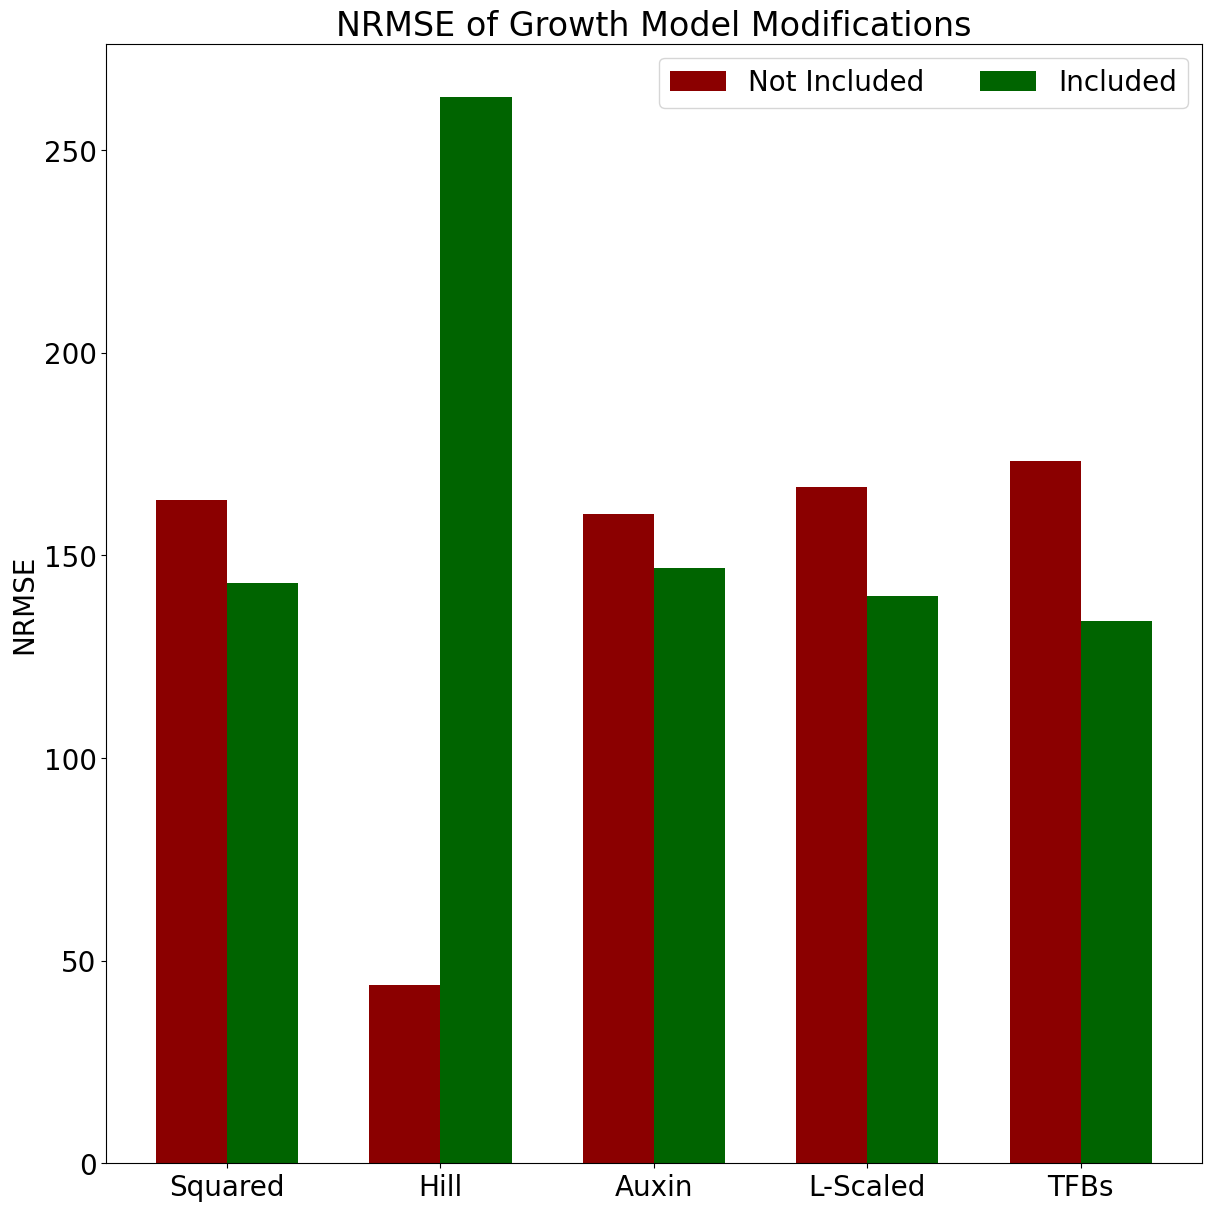

In [13]:
# Plot the mean error of the growth models
XLABELS = ["Squared", "Hill", "Auxin", "L-Scaled", "TFBs"]
bardata = {"Not Included": [], "Included": []}
for i, label in enumerate(XLABELS):
    error_false = sum([r[2] for r in results if r[0][i] == False]) / 16
    error_true  = sum([r[2] for r in results if r[0][i] == True]) / 16
    bardata["Not Included"].append(error_false)
    bardata["Included"].append(error_true)

# Change the colour cycler
colors = ["darkred", "darkgreen"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

# Construct the bar chart
mpl.rcParams['font.size'] = 20
fig, ax = plt.subplots(layout='constrained')
x = np.arange(len(XLABELS))
width, multiplier = 1/3, 0

# Plot the data
for attribute, measurement in bardata.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('NRMSE of Growth Model Modifications')
ax.set_ylabel('NRMSE')
ax.set_ylim(0, None)
ax.set_xticks(x + 1/6, XLABELS)
ax.legend(loc='upper right', ncols=2)
# plt.savefig("img/prototype-3d-modification-means.png", bbox_inches = "tight")
plt.show()

In [14]:
# Converts a config tuple into an xy location in 4x8 array
def get_position(config):
    x = sum([config[i] * (2 ** i) for i in range(2)])
    y = sum([config[i+2] * (2 ** i) for i in range(3)])
    return (x, y)

# Define the label arrays
XLABELS = ["", "Auxin", "L-Scaled", "L-Scaled, Auxin", "TFBs", 
           "TFBs, Auxin", "TFBs, L-Scaled", "TFBs, L-Scaled, Auxin"]
YLABELS = [r"$B$", r"$B^2$", r"$B$, Hill", r"$B^2$, Hill"]

# Create a mapping between config and label
mapdata = np.zeros((4, 8))
for r in results:
    config, data, error = r
    x, y = get_position(config)
    mapdata[x][y] = error

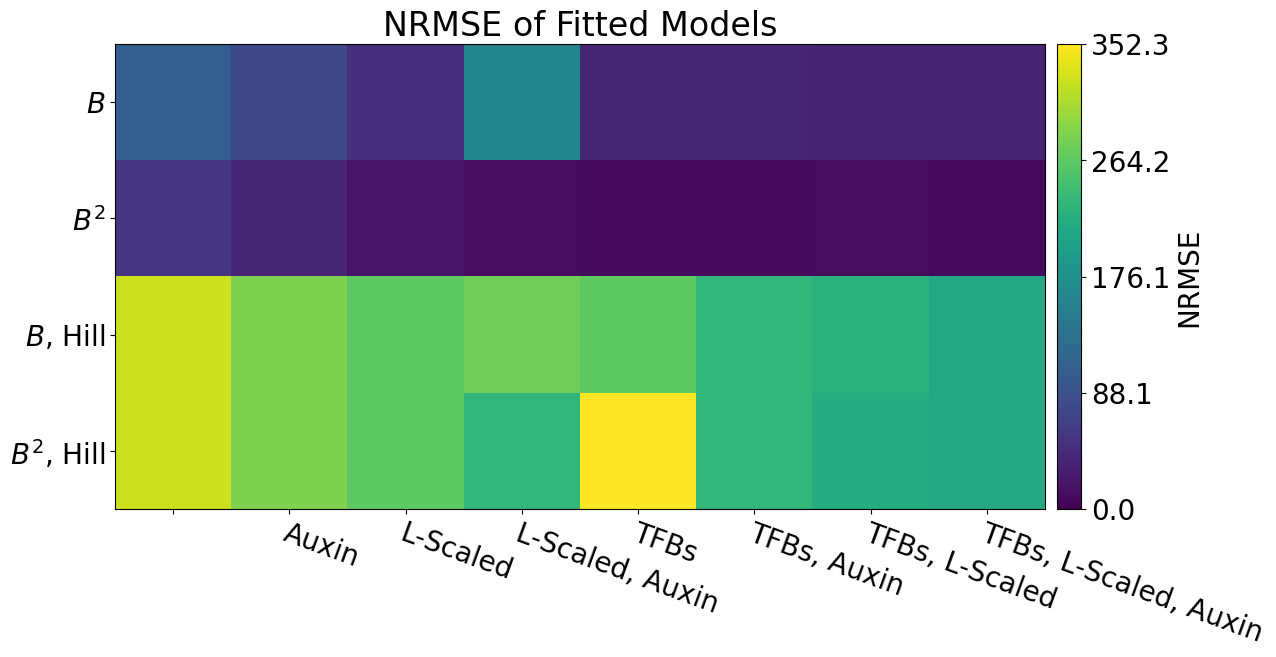

In [15]:
# Generate the heatmap
mpl.rcParams['font.size'] = 20
fig, ax = plt.subplots()
im = ax.imshow(mapdata, vmin = 0, vmax = np.max(mapdata))

# Create a colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = fig.colorbar(im, cax=cax, label = "NRMSE") 
cbar.set_ticks(np.linspace(0, np.max(mapdata), 5))

# Show all ticks and label them with the respective list entries.
ax.set_xticks(np.arange(8), labels=XLABELS)
ax.set_yticks(np.arange(4), labels=YLABELS)
ax.set_title("NRMSE of Fitted Models")

# Rotate the xtick labels so that they fit
plt.setp(ax.get_xticklabels(), rotation=-20, ha="left", rotation_mode="anchor")
# plt.savefig("img/prototype-3d-error-heatmap.png", bbox_inches = "tight")

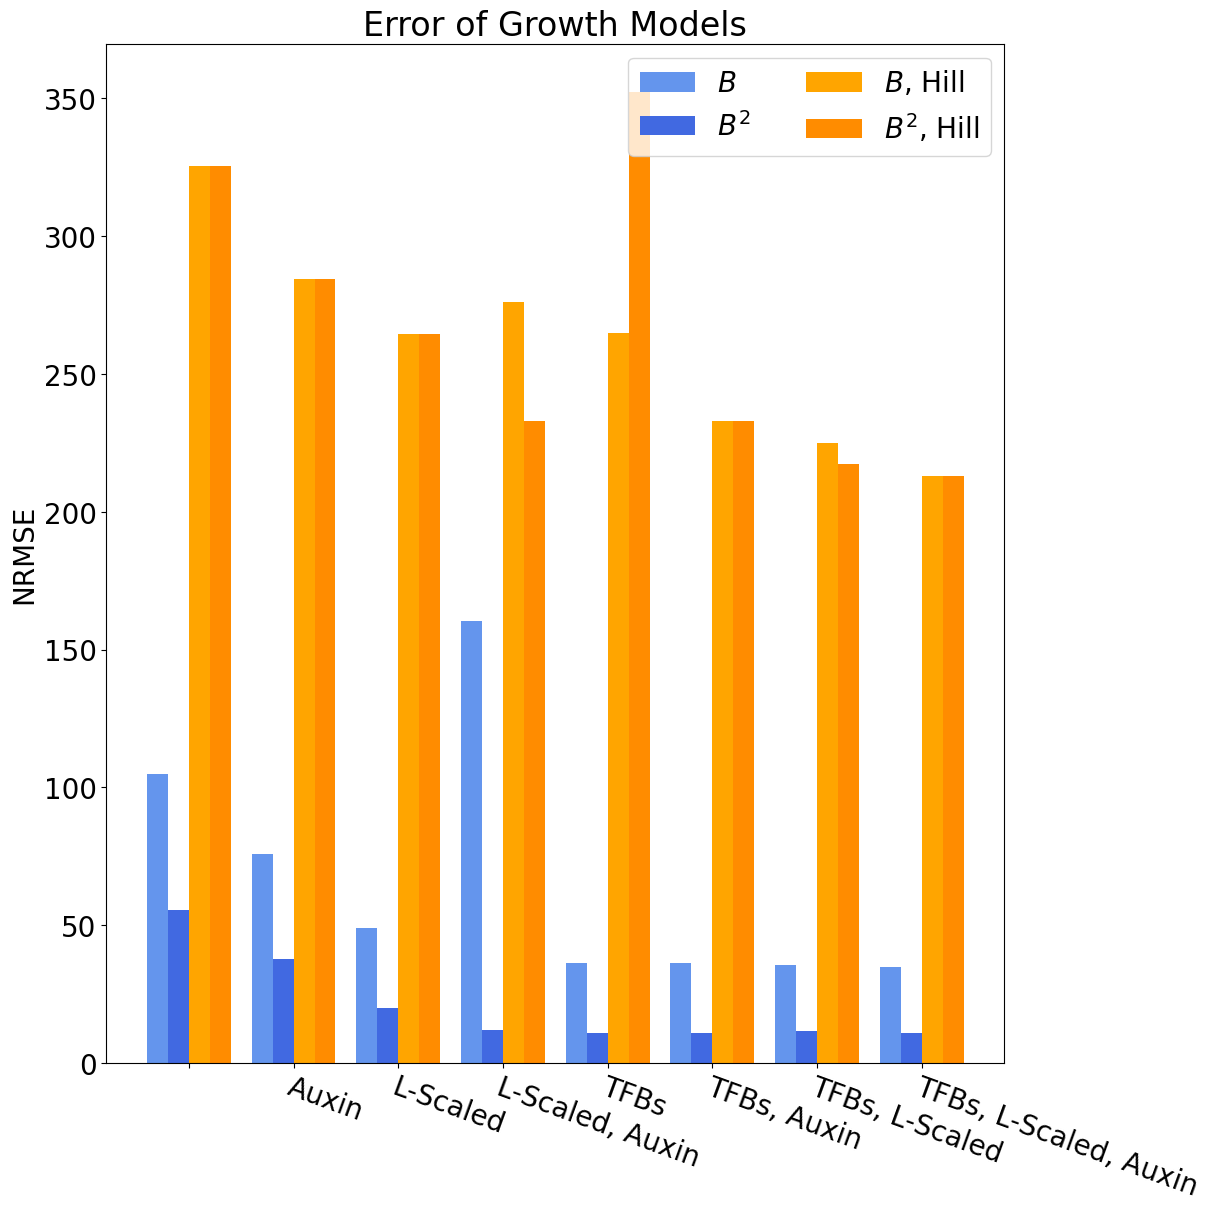

In [16]:
# Produce a dictionary of data and other variables for the bar chart
mpl.rcParams['font.size'] = 20
bardata = {label : row for label, row in zip(YLABELS, mapdata)}
x = np.arange(len(XLABELS)) 
width, multiplier = 0.2, 0

# Change the colour cycler
colors = ["cornflowerblue", "royalblue", "orange", "darkorange"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

# Construct the bar chart
fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in bardata.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Error of Growth Models')
ax.set_ylabel('NRMSE')
ax.set_ylim(0, None)
ax.set_xticks(x + 0.3, XLABELS)
ax.legend(loc='upper right', ncols=2)
plt.setp(ax.get_xticklabels(), rotation=-20, ha="left", rotation_mode="anchor")
# plt.savefig("img/prototype-3d-error-barchart.png", bbox_inches = "tight")
plt.show()